In [212]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import Loss
from tensorflow.keras.datasets import mnist

In [179]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.
x_test = np.expand_dims(x_test, -1)

In [47]:
image_shape = (28, 28, 1)
shape_before_flattening = (14, 14, 1)
batch_size = 16
latent_dim = 2

In [222]:
class Encoder(Layer):
    def __init__(self, latent_dim):
        super().__init__()
        self.hidden_layers = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding="same", activation="relu"),
            layers.Conv2D(64, 3, padding="same", activation="relu", strides=(2, 2)),
            layers.Conv2D(64, 3, padding="same", activation="relu"),
            layers.Conv2D(64, 3, padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(32, activation="relu")
        ])
        self.out1 = layers.Dense(latent_dim)
        self.out2 = layers.Dense(latent_dim)
        
    def call(self, inp):
        x = self.hidden_layers(inp)
        z_mean = self.out1(x)
        z_log_var = self.out2(x)
        return z_mean, z_log_var
    
encoder = Encoder(latent_dim)

In [223]:
(z_mean, z_log_var) = encoder(x_train[:1])
z_mean, z_log_var

(<tf.Tensor: id=23514062, shape=(1, 2), dtype=float32, numpy=array([[ 0.00530403, -0.01680136]], dtype=float32)>,
 <tf.Tensor: id=23514088, shape=(1, 2), dtype=float32, numpy=array([[ 0.0055132 , -0.02782456]], dtype=float32)>)

In [163]:
class Sampling(Layer):
    def call(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(z_mean.shape[0], latent_dim), mean=0.0, stddev=1.0)
        z = z_mean + tf.exp(z_log_var) * epsilon
        return z
    
sampling = Sampling()

In [164]:
sampling(z_mean, z_log_var)

<tf.Tensor: id=8257, shape=(1, 2), dtype=float32, numpy=array([[-0.55650645, -0.2533372 ]], dtype=float32)>

In [195]:
def Decoder(shape_before_flattening, latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(np.prod(shape_before_flattening), activation="relu"),
        layers.Reshape(shape_before_flattening),
        layers.Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2, 2)),
        layers.Conv2D(1, 3, padding="same", activation="sigmoid")
    ])
    return model
    
decoder = Decoder(shape_before_flattening, latent_dim)

In [200]:
y_pred = decoder(sampling(z_mean, z_log_var))
y_pred.shape

TensorShape([1, 28, 28, 1])

In [201]:
class CustomLossFunction:
    @staticmethod
    def reconstruction_loss(y_true, y_pred):
        y_true = layers.Flatten()(y_true)
        y_pred = layers.Flatten()(y_pred)
        loss = tf.keras.metrics.binary_crossentropy(y_true, y_pred)
        return loss
    
    @staticmethod
    def regularization_loss(z_mean, z_log_var):
        loss = -5e-4 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        return loss
    
    def vae_loss(self, y_true, y_pred, z_mean, z_log_var):
        rec_loss = self.reconstruction_loss(y_true, y_pred)
        reg_loss = self.regularization_loss(z_mean, z_log_var)
        loss = tf.reduce_mean(rec_loss + reg_loss)
        return loss
    
    def __call__(self, y_true, y_pred, z_mean, z_log_var):
        loss = self.vae_loss(y_true, y_pred, z_mean, z_log_var)
        return loss
    
loss_layer = CustomLossFunction()

In [202]:
loss = loss_layer(x_train[:1], y_pred, z_mean, z_log_var)
loss

<tf.Tensor: id=599070, shape=(), dtype=float32, numpy=0.6952246>

In [224]:
class VAE(Model):
    def __init__(self, shape_before_flattening, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(shape_before_flattening, latent_dim)
        
    def call(self, inp):
        z_mean, z_log_var = self.encoder(inp)
        z = self.sampling(z_mean, z_log_var)
        y_pred = self.decoder(z)
        return y_pred, z_mean, z_log_var
    
vae = VAE(shape_before_flattening, latent_dim)

In [225]:
y_pred, z_mean, z_log_var = vae(x_train[:1])
y_pred.shape, z_mean, z_log_var

(TensorShape([1, 28, 28, 1]),
 <tf.Tensor: id=23514256, shape=(1, 2), dtype=float32, numpy=array([[-0.01113138, -0.04219406]], dtype=float32)>,
 <tf.Tensor: id=23514282, shape=(1, 2), dtype=float32, numpy=array([[-0.02540235,  0.00989371]], dtype=float32)>)

In [209]:
def train(model, optimizer, train_data, validation_data, epochs=10, batch_size=16):
    # Create Tensorflow Dataset for train set
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
    train_dataset = train_dataset.shuffle(train_data.shape[0]).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    # Create Tensorflow Dataset for validation set
    validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data)
    validation_dataset = validation_dataset.batch(batch_size)
    
    # Define loss function
    loss_function = CustomLossFunction()
    
    # Define metrics
    train_loss = tf.keras.metrics.Mean(name="train_loss")
    train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
    val_loss = tf.keras.metrics.Mean(name="validation_loss")
    val_accuracy = tf.keras.metrics.BinaryAccuracy(name="validation_accuracy")
    
    # Start training
    for epoch in range(epochs):
        # Reset state
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()
        # Train batchs
        for batch, inp_images in enumerate(train_dataset):
            with tf.GradientTape() as g:
                g.watch(inp_images)
                output_images, z_mean, z_log_var = model(inp_images)
                loss = loss_function(inp_images, output_images, z_mean, z_log_var)
            grads = g.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # Record
            train_loss(loss)
            train_accuracy(inp_images, output_images)
            if (batch + 1) % 100 == 0:
                print("Epoch {} Batch {}: Loss {:.4f}, Accuracy {:.4f}" \
                      .format(epoch + 1, batch + 1, train_loss.result(), train_accuracy.result()))
        # Validation
        for batch, inp_images in enumerate(validation_dataset):
            output_images, z_mean, z_log_var = model(inp_images)
            loss = loss_function(inp_images, output_images, z_mean, z_log_var)
            # Record
            val_loss(loss)
            val_accuracy(inp_images, output_images)
        print("Epoch {}: Validation Loss {:.4f}, Validation Accuracy {:.4f}" \
              .format(epoch + 1, batch + 1, val_loss.result(), val_accuracy.result()))

In [214]:
model = VAE(shape_before_flattening, latent_dim)
optimizer = tf.keras.optimizers.Adam()
train(model, optimizer, x_train, x_test, epochs=10, batch_size=16)

Epoch 1 Batch 100: Loss 0.5208, Accuracy 0.8085
Epoch 1 Batch 200: Loss 0.4375, Accuracy 0.8099
Epoch 1 Batch 300: Loss 0.3964, Accuracy 0.8094
Epoch 1 Batch 400: Loss 0.3704, Accuracy 0.8089
Epoch 1 Batch 500: Loss 0.3506, Accuracy 0.8088
Epoch 1 Batch 600: Loss 0.3352, Accuracy 0.8090
Epoch 1 Batch 700: Loss 0.3230, Accuracy 0.8090
Epoch 1 Batch 800: Loss 0.3133, Accuracy 0.8091
Epoch 1 Batch 900: Loss 0.3054, Accuracy 0.8091
Epoch 1 Batch 1000: Loss 0.2986, Accuracy 0.8090
Epoch 1 Batch 1100: Loss 0.2929, Accuracy 0.8090
Epoch 1 Batch 1200: Loss 0.2879, Accuracy 0.8090
Epoch 1 Batch 1300: Loss 0.2837, Accuracy 0.8089
Epoch 1 Batch 1400: Loss 0.2801, Accuracy 0.8089
Epoch 1 Batch 1500: Loss 0.2770, Accuracy 0.8088
Epoch 1 Batch 1600: Loss 0.2740, Accuracy 0.8088
Epoch 1 Batch 1700: Loss 0.2713, Accuracy 0.8089
Epoch 1 Batch 1800: Loss 0.2691, Accuracy 0.8087
Epoch 1 Batch 1900: Loss 0.2670, Accuracy 0.8088
Epoch 1 Batch 2000: Loss 0.2651, Accuracy 0.8088
Epoch 1 Batch 2100: Loss 0.26

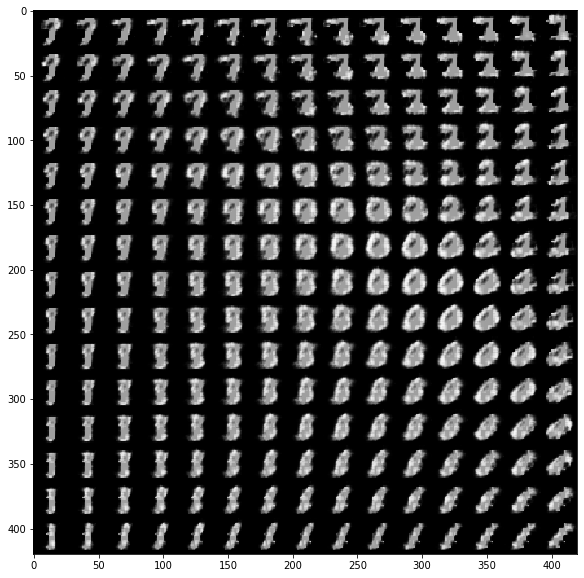

In [221]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = model.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()